In [1]:
from scipy import signal

def buffer_nans(da, kn):
    k = np.zeros((kn,kn))
    k[kn//2,kn//2] = 1

    arr = da.values
    mask = np.ones(arr.shape).astype(np.float32)

    for i in range(arr.shape[0]):
        mask[i,:,:] = signal.convolve2d(arr[i,:,:], k, boundary='fill', mode='same')

    return da.where(~np.isnan(mask))

In [3]:
import xarray as xr

for i in range(100):
    ds2018 = xr.open_dataset(f"/data/pca_act/{i:03d}_2018.nc")
    ds2019 = xr.open_dataset(f"/data/pca_act/{i:03d}_2019.nc")

    ds = xr.concat([ds2018, ds2019], dim='time').sortby('time')

    print(ds.nbart_blue.count(dim=('x','y')))

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 159774,
       159687, 158656, 158483, 156365, 150069, 149991, 146964, 146929,
       144183, 144437, 142013, 142572, 140830, 142331, 140782, 142058,
       143797, 144816, 146265, 147445, 149321, 150801, 152805, 154801,
       156182, 157718, 158591, 159363, 159858, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 159992, 159443, 159339, 158032, 157900,
       155394, 155218, 152251, 152131, 149011, 149042, 146033, 146182,
       143506, 144007, 141774, 142689, 141172,      0, 141810, 143459,
       143585, 145519, 148248, 14

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 159910,
       159939, 158933, 158955, 158088, 154830, 154880, 151722, 152039,
       148254, 149025, 145111, 146435, 143370, 146241, 143163, 144828,
       147703, 148739, 150885, 151837, 154096, 155242, 156654, 157453,
       157918, 158317, 159026, 159642, 159985, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 159999, 160000, 159712, 159794, 158594, 158671,
       157742, 157813, 156443, 156593, 154020, 154311, 150852, 151456,
       147565, 148861, 145030, 146950, 144108, 146523, 144837, 147733,
       147216, 150233, 153251, 15

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 159925,
       159944, 159656, 159708, 159246, 153828, 153852, 149154, 149503,
       145268, 145802, 142086, 143257, 140111, 142997, 139951, 141757,
       144689, 145920, 148158, 149488, 152681, 154432, 156701, 158322,
       159105, 159461, 159731, 159862, 159995, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 159874, 159910, 159577, 159635,
       158816, 158875, 156312, 156387, 152430, 152704, 147985, 148614,
       144417, 145408, 141944, 143570, 140908, 143265, 141726, 144421,
       144295, 147276, 151227, 15

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000,      0, 155248, 160000, 160000, 154110, 160000,
       156479, 160000, 157912, 160000, 159109, 160000, 146959, 160000,
       146103, 160000, 144676, 149226, 159888, 150376, 158735, 157021,
       156232, 156928, 152642, 154277, 150070, 153981, 149765, 152200,
       155058, 156720, 157959, 158717, 159283, 159928, 159956, 160000,
       159526, 160000, 159284, 160000, 156907, 160000, 160000, 138216,
       160000, 140842, 160000, 143516, 160000, 154257, 160000, 159293,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 152795, 160000, 152687, 160000, 153599, 160000, 157858,
       160000, 159471, 160000, 160000, 160000, 160000, 160000, 159939,
       160000, 158941, 160000, 158824, 160000, 157736, 160000, 157331,
       160000, 158407, 159993, 158484, 159686, 159771, 158270, 158671,
       155570, 156714, 152514, 154825, 151060, 154122, 152155, 154498,
       155216, 152187, 154014, 15

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 159929, 159938, 159598,
       159612, 158243, 158257, 155674, 144171, 144964, 138470, 139489,
       133070, 134662, 129185, 131160, 126933, 131038, 126564, 128368,
       132434, 133519, 137032, 137937, 142500, 144267, 148870, 152275,
       154979, 156755, 158390, 159236, 159750, 159910, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 159890, 159891, 159296, 159333, 157493, 157669,
       153900, 154375, 148372, 149273, 142614, 143798, 137183, 138762,
       132329, 134519, 129215, 131918, 127914,      0, 128639, 132714,
       131447, 136275, 141184, 14

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 159868,
       159890, 159415, 159478, 158344, 152219, 152718, 147849, 148763,
       143791, 145074, 140648, 142416, 138598, 142336, 138175, 139872,
       143323, 143971, 146678, 147361, 151010, 152405, 155218, 156931,
       158027, 158801, 159516, 159748, 159935, 159995, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 159987, 159988, 159781, 159825, 159155, 159258,
       157563, 157687, 154828, 155041, 151163, 151978, 146902, 148362,
       143341, 145091, 140781, 143126, 139592, 142611, 140245, 143685,
       142516, 146220, 150061, 15

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 154693, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 156459, 156970, 149585, 151023,
       141395, 143766, 134738, 137956, 130895, 137662, 130308, 133709,
       140294, 142275, 147334, 149108, 154969, 156665, 159170, 159913,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       159995, 160000, 158935, 159163, 155030, 156070, 147577, 149886,
       140157, 143548, 134782, 139327, 132627, 138275, 134005, 140738,
       138961, 146285, 153363, 15

<xarray.DataArray 'nbart_blue' (time: 129)>
array([     0, 160000,      0,      0, 160000, 160000,      0, 160000,
            0, 160000,      0, 160000,      0, 160000,      0, 159992,
            0, 159925,      0,      0, 158368,      0, 157555,      0,
       156457,      0, 155318,      0, 154598,      0, 154515, 155141,
            0, 156578,      0, 157450,      0, 158349,      0, 159362,
            0, 159817,      0, 159972,      0, 160000, 160000,      0,
       160000,      0, 160000,      0, 160000,      0, 160000,      0,
       160000,      0, 160000,      0, 160000,      0, 160000,      0,
       160000,      0, 160000,      0, 160000,      0, 160000,      0,
       160000,      0, 160000,      0, 160000,      0, 160000,      0,
       160000,      0, 160000,      0, 159975,      0, 159887,      0,
       159528,      0, 158953,      0, 158194,      0, 157347,      0,
       156249,      0, 155317,      0, 154926,      0, 155166,      0,
       156054,      0,      0, 15

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 159997, 159998, 159457, 159647, 158469, 158784, 157181,
       157377, 154741, 155156, 150676, 131389, 133722, 121349, 124447,
       112553, 116182, 106274, 110536, 102573, 110655, 101679, 104260,
       111635, 112247, 118546, 118853, 128070, 130404, 139104, 144233,
       149153, 151811, 155400, 156567, 157927, 158541, 159812, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 159930, 159993,
       159234, 159533, 158275, 158454, 156666, 157008, 153597, 154321,
       147350, 148774, 138656, 141044, 128999, 132361, 119647, 123900,
       111880, 116741, 106695, 112419, 104387, 111026, 105248, 113002,
       109375, 118278, 126516, 12

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 159556, 159498, 159044, 158955,
       158352, 158331, 157528, 157615, 157045, 157477, 157086, 157657,
       158217, 158629, 158909, 159237, 159458, 159675, 159849, 159991,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       159999, 159991, 159776, 159724, 159385, 159311, 158806, 158733,
       158083, 158119, 157385, 157613, 157157, 157556, 157490, 158015,
       158210, 158663, 159252, 15

<xarray.DataArray 'nbart_blue' (time: 129)>
array([ 61226, 160000,      0,  24229, 160000, 160000,  20719, 160000,
        25841, 160000,  31068, 160000,  35338, 159923,  11154, 159595,
        10572, 157732,   9502,  13711, 142046,  15665, 137419,  29759,
       132309,  49032, 128567,  75536, 126527,  65544, 126111, 127702,
        36199, 132493,  38654, 136767,  37917, 142075,  42260, 149294,
        38657, 155436,  37804, 159354,  25563, 159961, 160000,   5447,
       160000,   6651, 160000,   8241, 160000,  20740, 160000,  37333,
       160000,  57804, 160000,  87512, 160000,  69386, 160000,  55736,
       160000,  19708, 160000,  19572, 160000,  20523, 160000,  31323,
       160000,  38538, 160000,  51399, 160000,  68921, 160000,  44581,
       160000,  35734, 159888,  34736, 159416,  31670, 156679,  29679,
       151419,  32520, 145650,  33436, 140912,  44671, 136378,  64596,
       131745,  76581, 128759,  54932, 127577,  41845, 128119,  33357,
       130696,  22684,  23290, 14

<xarray.DataArray 'nbart_blue' (time: 129)>
array([    0, 62800,     0,     0, 62800, 62800,     0, 62800,     0,
       62800,     0, 62800,     0, 62800,     0, 62800,     0, 62800,
           0,     0, 62617,     0, 62316,     0, 61593,     0, 60820,
           0, 60338,     0, 60307, 60799,     0, 61705,     0, 62275,
           0, 62635,     0, 62800,     0, 62800,     0, 62800,     0,
       62800, 62800,     0, 62800,     0, 62800,     0, 62800,     0,
       62800,     0, 62800,     0, 62800,     0, 62800,     0, 62800,
           0, 62800,     0, 62800,     0, 62800,     0, 62800,     0,
       62800,     0, 62800,     0, 62800,     0, 62800,     0, 62800,
           0, 62800,     0, 62800,     0, 62800,     0, 62800,     0,
       62774,     0, 62523,     0, 62160,     0, 61435,     0, 60774,
           0, 60519,     0, 60744,     0, 61403,     0,     0, 62499,
           0, 62796,     0, 62800,     0, 62800,     0, 62800,     0,
       62800,     0, 62800,     0, 62800,     

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 159994, 160000, 159921, 159951, 159624,
       159650, 158417, 158509, 156112, 146107, 146539, 140902, 141512,
       136436, 137270, 133131, 134438, 131200, 134208, 131027, 132788,
       135865, 137039, 139605, 140845, 144703, 146614, 150192, 153158,
       155487, 157191, 158644, 159289, 159804, 159922, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 160000,
       159993, 159999, 159888, 159911, 159364, 159461, 157847, 158012,
       154476, 154914, 149723, 150230, 144611, 145380, 139545, 140561,
       135657, 136963, 132999, 134890, 131948, 134477, 132748, 135786,
       135329, 138736, 143316, 14

<xarray.DataArray 'nbart_blue' (time: 129)>
array([160000, 160000, 160000, 151837, 160000, 160000, 149241, 160000,
       152687, 160000, 155722, 160000, 156940, 160000, 139853, 159911,
       139082, 159000, 137508, 140862, 147982, 135840, 139513, 137195,
       130736, 132440, 124225, 126783, 120502, 126312, 120106, 123591,
       127881, 131995, 135620, 139789, 144320, 149087, 151395, 155381,
       154135, 157919, 156342, 159713, 152435, 160000, 160000, 131440,
       160000, 131877, 160000, 136867, 160000, 149564, 160000, 157135,
       160000, 160000, 160000, 160000, 160000, 160000, 160000, 159996,
       160000, 148446, 160000, 148474, 160000, 149313, 160000, 154931,
       160000, 157618, 160000, 159766, 160000, 160000, 160000, 159080,
       160000, 156635, 159996, 156163, 159746, 154877, 158323, 152043,
       156109, 151280, 152172, 148732, 145543, 145290, 137080, 138743,
       129201, 131943, 124042, 127718, 122034, 126226, 123570, 126575,
       128543, 129054, 136688, 14

<xarray.DataArray 'nbart_blue' (time: 129)>
array([     0, 160000,      0,      0, 160000, 160000,      0, 160000,
            0, 160000,      0, 160000,      0, 159967,      0, 159809,
            0, 158667,      0,      0, 141806,      0, 134917,      0,
       128781,      0, 123962,      0, 120827,      0, 120255, 123105,
            0, 129150,      0, 134525,      0, 142389,      0, 151966,
            0, 157101,      0, 159640,      0, 159971, 160000,      0,
       160000,      0, 160000,      0, 160000,      0, 160000,      0,
       160000,      0, 160000,      0, 160000,      0, 160000,      0,
       160000,      0, 160000,      0, 160000,      0, 160000,      0,
       160000,      0, 160000,      0, 160000,      0, 160000,      0,
       160000,      0, 159943,      0, 159670,      0, 157881,      0,
       154000,      0, 146894,      0, 139838,      0, 133237,      0,
       127913,      0, 123996,      0, 122217,      0, 123386,      0,
       127042,      0,      0, 13

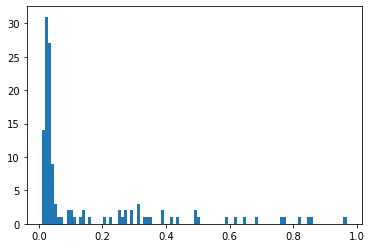

In [6]:
%matplotlib inline

from matplotlib import pyplot as plt

_ = plt.hist(ds.nbart_blue.isel(x=200, y=200).values.flatten()/10000, bins=100)

In [36]:
blue = ds[band_name].astype(np.float32) / 1e4
# 1.- Filter reflectances greater than 0.5 
blue = blue.where(blue<.4)

# 2.- Filter reflectances with difference to lower quartile larger than 0.05 => (0.07)
#blue = blue.where((blue - blue.quantile(0.25, dim='time'))<.05)


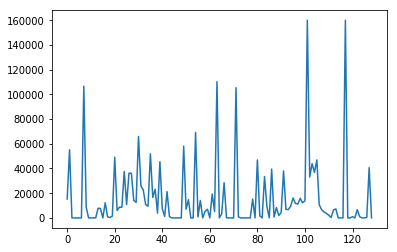

In [46]:
%matplotlib inline

np.count_nonzero(np.isnan(blue.isel(time=-2)))


plt.plot(np.count_nonzero(np.isnan(blue),axis=(1,2)))

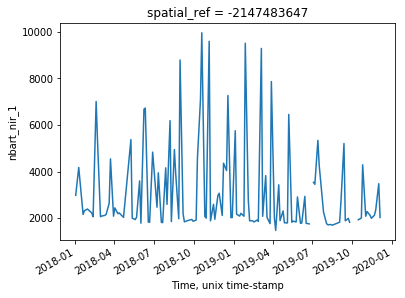

In [51]:
ds.nbart_nir_1.mean(dim=("x","y")).plot()

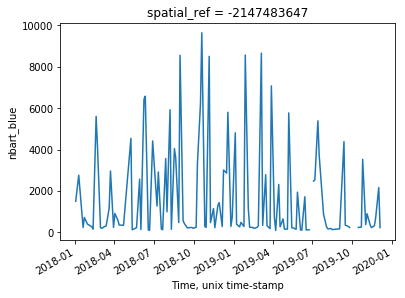

In [52]:
ds.nbart_blue.mean(dim=("x","y")).plot()

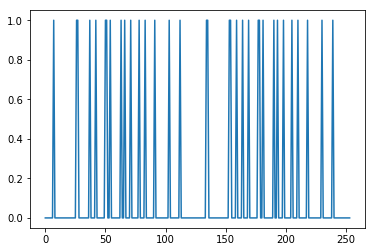

In [58]:
from sklearn.cluster import KMeans

X1 = ds.nbart_blue.isel(x=100,y=100).values
X2 = ds.nbart_nir_1.isel(x=100,y=100).values
X = np.hstack((X1,X2))
X = X[~np.isnan(X)]

kmeans = KMeans(n_clusters=2, random_state=0).fit(X.reshape(-1,1))

kmeans.labels_, kmeans.cluster_centers_

plt.plot(kmeans.labels_)

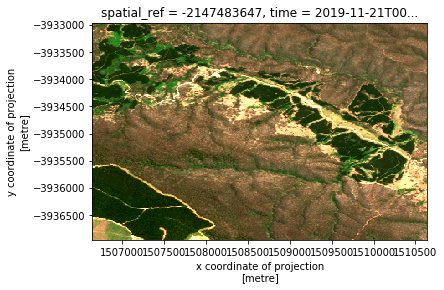

In [38]:
ds[['nbart_red','nbart_green','nbart_blue']].where(~np.isnan(blue)).isel(time=-4).to_array().plot.imshow(robust=True)

In [16]:
ds.nbart_blue.x.values[0], ds.nbart_blue.y.values[0], ds.nbart_blue.y.values[-1]

(1506645.0, -3932965.0, -3936955.0)

In [10]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

ds2018 = xr.open_dataset("/data/pca_act/000_2018.nc")
ds2019 = xr.open_dataset("/data/pca_act/000_2019.nc")

ds = xr.concat([ds2018, ds2019], dim='time').sortby('time')

blue = ds[band_name].astype(np.float32) / 1e4
# 1.- Filter reflectances greater than 0.5 
blue = blue.where(blue<.5)

# 2.- Filter reflectances with difference to lower quartile larger than 0.05 => (0.07)
blue = blue.where((blue - blue.quantile(0.25, dim='time'))<.07)

# 3.- Grow a 5x5 buffer around NaN pixels 
blue = buffer_nans(blue, 5)

# 4.- Discard frames with more than 25% missing pixels
blue = blue.isel(time=(blue.count(dim=('x','y'))/(400*400))>.25)


stack = np.empty((0,400,400))

for band_name in ds:
    
    band = ds[band_name].astype(np.float32) / 1e4
    
    # 1. Apply blue mask
    band = band.sel(time=blue.time).where(~np.isnan(blue))

    # 2.- Interpolate NaNs over time linearly
    band = band.interpolate_na(dim='time')

    # 3.- Interpolate NaNs at the start and end using nearest neighbor
    band = band.interpolate_na(dim='time', method='nearest', fill_value='extrapolate')

    # 4.- Apply median rolling filter along time (window=3)
    band = band.rolling(time=3, min_periods=1).median()
    
    stack = np.append(stack, band, axis=0)
    
    print(stack.shape)

(94, 400, 400)
(188, 400, 400)
(282, 400, 400)
(376, 400, 400)
(470, 400, 400)
(564, 400, 400)
(658, 400, 400)


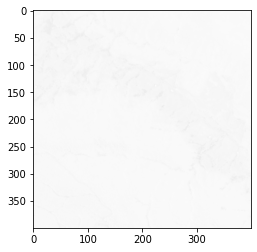

In [15]:
import imageio

im = imageio.imread("/data/pca_act/tiles/000_000_2018-01-20.png")

im.shape, im.dtype

plt.imshow(im)

(array([89.,  9.,  4.,  4.,  5.,  5.,  1.,  5.,  2.,  3.]),
 array([0.0012 , 0.10108, 0.20096, 0.30084, 0.40072, 0.5006 , 0.60048,
        0.70036, 0.80024, 0.90012, 1.     ], dtype=float32),
 <BarContainer object of 10 artists>)

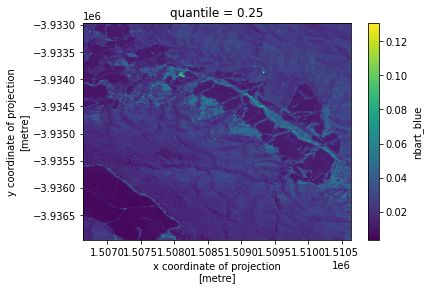

In [8]:
%matplotlib inline

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

ds2018 = xr.open_dataset("/data/pca_act/000_2018.nc")
ds2019 = xr.open_dataset("/data/pca_act/000_2019.nc")

ds = xr.concat([ds2018, ds2019], dim='time').sortby('time')

blue = ds.nbart_blue.astype(np.float32) / 1e4

#blue.quantile(0.25, dim='time').plot()

In [11]:
blue.mode(dim='time').plot()

AttributeError: 'DataArray' object has no attribute 'mode'

(array([17., 18., 33., 13.,  3.,  0.,  1.,  3.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  1.,  4.,  1.,  0.,  2.,  2.,  1.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.,  0.,  0.,  1.,
         0.,  0.,  2.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.]),
 array([0.0012  , 0.011188, 0.021176, 0.031164, 0.041152, 0.05114 ,
        0.061128, 0.071116, 0.081104, 0.091092, 0.10108 , 0.111068,
        0.121056, 0.131044, 0.141032, 0.15102 , 0.161008, 0.170996,
        0.180984, 0.190972, 0.20096 , 0.210948, 0.220936, 0.230924,
        0.240912, 0.2509  , 0.260888, 0.270876, 0.280864, 0.290852,
        0.30084 , 0.310828, 0.320816, 0.330804, 0.340792, 0.35078 ,
        0.360768, 0.370756

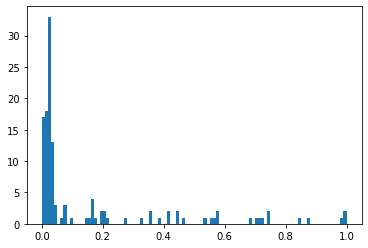

In [10]:
plt.hist(blue.isel(x=0,y=0).values.flatten(), bins=100)

In [11]:
from sklearn.decomposition import PCA
    
stack = stack.reshape(stack.shape[0], -1)

pca = PCA().fit(stack)
coeffs = pca.transform(stack)
pcs = pca.components_.reshape(-1,400,400)
mean = pca.mean_.reshape(-1,400,400)

stack.shape

(658, 160000)

In [13]:
from ipywidgets import interactive
import ipywidgets as widgets
    
def plot_rgb(t, n):
    red_rec = np.copy(pca.mean_.reshape((400,400)))
    green_rec = np.copy(pca.mean_.reshape((400,400)))
    blue_rec = np.copy(pca.mean_.reshape((400,400)))
    
    for n_pc in range(n):
        red_rec += coeffs[t,n_pc] * pcs[n_pc]
        green_rec += coeffs[94+t,n_pc] * pcs[n_pc]
        blue_rec += coeffs[188+t,n_pc] * pcs[n_pc]
        
    f, axarr = plt.subplots(1, 2, figsize=(12,6))

    rec_rgb = np.dstack((red_rec,green_rec,blue_rec))
    rgb = np.dstack((stack[t],stack[94+t],stack[188+t])).reshape(400,400,3)
    
    axarr[0].imshow(3*rgb)
    axarr[1].imshow(3*rec_rgb)

interactive_plot = interactive(plot_rgb, 
                               t=widgets.IntSlider(min=0, max=105, step=1, 
                                                   value=0, continuous_update=False),
                               n=widgets.IntSlider(min=0, max=20, step=1, 
                                                   value=20, continuous_update=False))
output = interactive_plot.children[-1]
output.layout.height = '350px'

interactive_plot

interactive(children=(IntSlider(value=0, continuous_update=False, description='t', max=105), IntSlider(value=2…

### Decompose original data using 20 PCs

In [31]:
pca = PCA(n_components=20).fit(stack)
stackT = pca.transform(stack)

stackT.shape

(735, 20)

### Regenerate initial data using the decomposed components

In [32]:
rec_stack = pca.inverse_transform(stackT)

rec_stack.shape

(735, 160000)

### Write video comparing RGB time series of the original data (left) and recreated PCA (right)

In [37]:
import imageio

writer = imageio.get_writer('video.mp4', fps=2)

for t in range(105):
    orig_r = stack[0*105+t].reshape((400,400))
    rec_r = rec_stack[0*105+t].reshape((400,400))
    orig_g = stack[1*105+t].reshape((400,400))
    rec_g = rec_stack[1*105+t].reshape((400,400))
    orig_b = stack[2*105+t].reshape((400,400))
    rec_b = rec_stack[2*105+t].reshape((400,400))
    
    writer.append_data(3*np.concatenate((np.dstack((orig_r,orig_g,orig_b)),np.dstack((rec_r,rec_g,rec_b))), axis=1))

writer.close()

In [34]:
from IPython.display import Video

Video("video.mp4")

In [9]:
coefs = pca.transform(stack)
comps = pca.components_

def plot_img(band, t):     
    f, axarr = plt.subplots(1,2)
    orig = stack[band*105+t].reshape((400,400))
    rec = rec_stack[band*105+t].reshape((400,400))
    
    axarr[0].imshow(orig, vmin=0, vmax=orig.max())
    axarr[1].imshow(rec, vmin=0, vmax=orig.max())
    
    print(orig.max(), rec.max())
    
def plot_rgb(t):     
    f, axarr = plt.subplots(1,2)
    
    orig_r = stack[0*105+t].reshape((400,400))
    rec_r = rec_stack[0*105+t].reshape((400,400))
    orig_g = stack[1*105+t].reshape((400,400))
    rec_g = rec_stack[1*105+t].reshape((400,400))
    orig_b = stack[2*105+t].reshape((400,400))
    rec_b = rec_stack[2*105+t].reshape((400,400))
    
    axarr[0].imshow(np.dstack((orig_r,orig_g,orig_b))*3)
    axarr[1].imshow(np.dstack((rec_r,rec_g,rec_b))*3)

In [16]:
%matplotlib inline

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from numpngw import write_png
from scipy import signal

def buffer_nans(da, kn):
    k = np.zeros((kn,kn))
    k[kn//2,kn//2] = 1

    arr = da.values
    mask = np.ones(arr.shape).astype(np.float32)

    for i in range(arr.shape[0]):
        mask[i,:,:] = signal.convolve2d(arr[i,:,:], k, boundary='fill', mode='same')

    return da.where(~np.isnan(mask))

for j in range(18):
    for i in range(26):
        """
        ds2018 = xr.open_dataset(f"/data/pca_act/{26*j+i:03d}_2018.nc")
        ds2019 = xr.open_dataset(f"/data/pca_act/{26*j+i:03d}_2019.nc")

        ds = xr.concat([ds2018, ds2019], dim='time').sortby('time')
        """
        ds = xr.open_dataset(f"/data/pca_act/{26*j+i:03d}_2018.nc")
        
        
        blue = ds.nbart_blue.astype(np.float32) / 1e4

        # 1.- Filter reflectances greater than 0.5 
        blue = blue.where(blue<.5)

        # 2.- Filter reflectances with difference to lower quartile larger than 0.05 => (0.07)
        blue = blue.where((blue - blue.quantile(0.25, dim='time'))<.07)

        # 3.- Grow a 5x5 buffer around NaN pixels 
        blue = buffer_nans(blue, 5)

        # 4.- Discard frames with more than 25% missing pixels
        blue = blue.isel(time=(blue.count(dim=('x','y'))/(400*400))>.25)
        
        # 5. Apply blue mask over entire dataset
        ds = ds.sel(time=blue.time).where(~np.isnan(blue))
        
        for t in ds.time[:6]:
            mask = np.isnan(blue.sel(time=t).values)
            mask = mask.astype(np.uint16) - 1
            
            print(f"/data/pca_act/tiles/clean_raw_{j:03d}_{i:03d}_{str(t.values)[-30:-19]}.png")
            stack = np.dstack((ds.nbart_red.sel(time=t).astype(np.uint16).values,
                               ds.nbart_green.sel(time=t).astype(np.uint16).values,
                               ds.nbart_blue.sel(time=t).astype(np.uint16).values,
                               mask))

            write_png(f"/data/pca_act/tiles/clean_raw_{j:03d}_{i:03d}_{str(t.values)[-30:-19]}.png", stack.astype(np.uint16))


/data/pca_act/tiles/clean_raw_000_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_000_000_2018-01-10.png
/data/pca_act/tiles/clean_raw_000_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_000_000_2018-01-23.png
/data/pca_act/tiles/clean_raw_000_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_000_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_000_001_2018-01-03.png
/data/pca_act/tiles/clean_raw_000_001_2018-01-10.png
/data/pca_act/tiles/clean_raw_000_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_000_001_2018-01-23.png
/data/pca_act/tiles/clean_raw_000_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_000_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_000_002_2018-01-03.png
/data/pca_act/tiles/clean_raw_000_002_2018-01-10.png
/data/pca_act/tiles/clean_raw_000_002_2018-01-20.png
/data/pca_act/tiles/clean_raw_000_002_2018-01-23.png
/data/pca_act/tiles/clean_raw_000_002_2018-01-30.png
/data/pca_act/tiles/clean_raw_000_002_2018-02-09.png
/data/pca_act/tiles/clean_raw_000_003_2018-01-

/data/pca_act/tiles/clean_raw_000_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_001_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_001_000_2018-01-10.png
/data/pca_act/tiles/clean_raw_001_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_001_000_2018-01-23.png
/data/pca_act/tiles/clean_raw_001_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_001_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_001_001_2018-01-03.png
/data/pca_act/tiles/clean_raw_001_001_2018-01-10.png
/data/pca_act/tiles/clean_raw_001_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_001_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_001_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_001_001_2018-02-12.png
/data/pca_act/tiles/clean_raw_001_002_2018-01-03.png
/data/pca_act/tiles/clean_raw_001_002_2018-01-10.png
/data/pca_act/tiles/clean_raw_001_002_2018-01-20.png
/data/pca_act/tiles/clean_raw_001_002_2018-01-30.png
/data/pca_act/tiles/clean_raw_001_002_2018-02-09.png
/data/pca_act/tiles/clean_raw_001_002_2018-02-

/data/pca_act/tiles/clean_raw_001_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_001_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_002_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_002_000_2018-01-10.png
/data/pca_act/tiles/clean_raw_002_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_002_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_002_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_002_000_2018-02-12.png
/data/pca_act/tiles/clean_raw_002_001_2018-01-03.png
/data/pca_act/tiles/clean_raw_002_001_2018-01-10.png
/data/pca_act/tiles/clean_raw_002_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_002_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_002_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_002_001_2018-02-12.png
/data/pca_act/tiles/clean_raw_002_002_2018-01-03.png
/data/pca_act/tiles/clean_raw_002_002_2018-01-10.png
/data/pca_act/tiles/clean_raw_002_002_2018-01-20.png
/data/pca_act/tiles/clean_raw_002_002_2018-01-30.png
/data/pca_act/tiles/clean_raw_002_002_2018-02-

/data/pca_act/tiles/clean_raw_002_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_002_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_002_025_2018-06-19.png
/data/pca_act/tiles/clean_raw_003_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_003_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_003_000_2018-01-23.png
/data/pca_act/tiles/clean_raw_003_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_003_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_003_000_2018-02-12.png
/data/pca_act/tiles/clean_raw_003_001_2018-01-03.png
/data/pca_act/tiles/clean_raw_003_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_003_001_2018-01-23.png
/data/pca_act/tiles/clean_raw_003_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_003_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_003_001_2018-02-12.png
/data/pca_act/tiles/clean_raw_003_002_2018-01-20.png
/data/pca_act/tiles/clean_raw_003_002_2018-01-30.png
/data/pca_act/tiles/clean_raw_003_002_2018-02-09.png
/data/pca_act/tiles/clean_raw_003_002_2018-02-

/data/pca_act/tiles/clean_raw_003_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_003_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_003_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_003_025_2018-07-09.png
/data/pca_act/tiles/clean_raw_004_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_004_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_004_000_2018-01-23.png
/data/pca_act/tiles/clean_raw_004_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_004_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_004_000_2018-02-12.png
/data/pca_act/tiles/clean_raw_004_001_2018-01-03.png
/data/pca_act/tiles/clean_raw_004_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_004_001_2018-01-23.png
/data/pca_act/tiles/clean_raw_004_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_004_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_004_001_2018-02-12.png
/data/pca_act/tiles/clean_raw_004_002_2018-01-20.png
/data/pca_act/tiles/clean_raw_004_002_2018-01-30.png
/data/pca_act/tiles/clean_raw_004_002_2018-02-

/data/pca_act/tiles/clean_raw_004_025_2018-03-01.png
/data/pca_act/tiles/clean_raw_004_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_004_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_004_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_004_025_2018-07-09.png
/data/pca_act/tiles/clean_raw_005_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_005_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_005_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_005_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_005_000_2018-02-12.png
/data/pca_act/tiles/clean_raw_005_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_005_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_005_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_005_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_005_001_2018-02-12.png
/data/pca_act/tiles/clean_raw_005_001_2018-03-01.png
/data/pca_act/tiles/clean_raw_005_001_2018-03-04.png
/data/pca_act/tiles/clean_raw_005_002_2018-01-03.png
/data/pca_act/tiles/clean_raw_005_002_2018-01-

/data/pca_act/tiles/clean_raw_005_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_005_025_2018-03-01.png
/data/pca_act/tiles/clean_raw_005_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_005_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_005_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_005_025_2018-07-09.png
/data/pca_act/tiles/clean_raw_006_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_006_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_006_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_006_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_006_000_2018-02-12.png
/data/pca_act/tiles/clean_raw_006_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_006_001_2018-01-03.png
/data/pca_act/tiles/clean_raw_006_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_006_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_006_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_006_001_2018-02-12.png
/data/pca_act/tiles/clean_raw_006_001_2018-03-01.png
/data/pca_act/tiles/clean_raw_006_002_2018-01-

/data/pca_act/tiles/clean_raw_006_024_2018-05-20.png
/data/pca_act/tiles/clean_raw_006_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_006_025_2018-03-01.png
/data/pca_act/tiles/clean_raw_006_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_006_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_006_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_006_025_2018-07-09.png
/data/pca_act/tiles/clean_raw_007_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_007_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_007_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_007_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_007_000_2018-02-12.png
/data/pca_act/tiles/clean_raw_007_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_007_001_2018-01-03.png
/data/pca_act/tiles/clean_raw_007_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_007_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_007_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_007_001_2018-02-12.png
/data/pca_act/tiles/clean_raw_007_001_2018-03-

/data/pca_act/tiles/clean_raw_007_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_007_024_2018-05-10.png
/data/pca_act/tiles/clean_raw_007_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_007_025_2018-03-01.png
/data/pca_act/tiles/clean_raw_007_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_007_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_007_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_007_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_008_000_2018-01-03.png
/data/pca_act/tiles/clean_raw_008_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_008_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_008_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_008_000_2018-02-12.png
/data/pca_act/tiles/clean_raw_008_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_008_001_2018-01-03.png
/data/pca_act/tiles/clean_raw_008_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_008_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_008_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_008_001_2018-02-

/data/pca_act/tiles/clean_raw_008_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_008_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_008_024_2018-05-10.png
/data/pca_act/tiles/clean_raw_008_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_008_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_008_025_2018-03-01.png
/data/pca_act/tiles/clean_raw_008_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_008_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_008_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_009_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_009_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_009_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_009_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_009_000_2018-03-11.png
/data/pca_act/tiles/clean_raw_009_000_2018-03-21.png
/data/pca_act/tiles/clean_raw_009_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_009_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_009_001_2018-02-09.png
/data/pca_act/tiles/clean_raw_009_001_2018-03-

/data/pca_act/tiles/clean_raw_009_024_2018-03-01.png
/data/pca_act/tiles/clean_raw_009_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_009_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_009_024_2018-05-10.png
/data/pca_act/tiles/clean_raw_009_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_009_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_009_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_009_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_009_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_009_025_2018-08-18.png
/data/pca_act/tiles/clean_raw_010_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_010_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_010_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_010_000_2018-02-19.png
/data/pca_act/tiles/clean_raw_010_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_010_000_2018-03-11.png
/data/pca_act/tiles/clean_raw_010_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_010_001_2018-01-30.png
/data/pca_act/tiles/clean_raw_010_001_2018-02-

/data/pca_act/tiles/clean_raw_010_024_2018-01-30.png
/data/pca_act/tiles/clean_raw_010_024_2018-02-09.png
/data/pca_act/tiles/clean_raw_010_024_2018-03-01.png
/data/pca_act/tiles/clean_raw_010_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_010_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_010_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_010_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_010_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_010_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_010_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_010_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_011_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_011_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_011_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_011_000_2018-02-19.png
/data/pca_act/tiles/clean_raw_011_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_011_000_2018-03-11.png
/data/pca_act/tiles/clean_raw_011_001_2018-01-20.png
/data/pca_act/tiles/clean_raw_011_001_2018-01-

/data/pca_act/tiles/clean_raw_011_024_2018-01-10.png
/data/pca_act/tiles/clean_raw_011_024_2018-01-30.png
/data/pca_act/tiles/clean_raw_011_024_2018-02-09.png
/data/pca_act/tiles/clean_raw_011_024_2018-03-01.png
/data/pca_act/tiles/clean_raw_011_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_011_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_011_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_011_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_011_025_2018-02-09.png
/data/pca_act/tiles/clean_raw_011_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_011_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_011_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_012_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_012_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_012_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_012_000_2018-02-19.png
/data/pca_act/tiles/clean_raw_012_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_012_000_2018-03-11.png
/data/pca_act/tiles/clean_raw_012_001_2018-01-

/data/pca_act/tiles/clean_raw_012_023_2018-03-31.png
/data/pca_act/tiles/clean_raw_012_024_2018-01-10.png
/data/pca_act/tiles/clean_raw_012_024_2018-01-30.png
/data/pca_act/tiles/clean_raw_012_024_2018-02-09.png
/data/pca_act/tiles/clean_raw_012_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_012_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_012_024_2018-05-10.png
/data/pca_act/tiles/clean_raw_012_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_012_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_012_025_2018-02-09.png
/data/pca_act/tiles/clean_raw_012_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_012_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_012_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_013_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_013_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_013_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_013_000_2018-02-19.png
/data/pca_act/tiles/clean_raw_013_000_2018-03-01.png
/data/pca_act/tiles/clean_raw_013_000_2018-03-

/data/pca_act/tiles/clean_raw_013_023_2018-03-31.png
/data/pca_act/tiles/clean_raw_013_023_2018-05-10.png
/data/pca_act/tiles/clean_raw_013_024_2018-01-10.png
/data/pca_act/tiles/clean_raw_013_024_2018-01-30.png
/data/pca_act/tiles/clean_raw_013_024_2018-02-09.png
/data/pca_act/tiles/clean_raw_013_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_013_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_013_024_2018-05-10.png
/data/pca_act/tiles/clean_raw_013_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_013_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_013_025_2018-02-09.png
/data/pca_act/tiles/clean_raw_013_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_013_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_013_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_014_000_2018-01-20.png
/data/pca_act/tiles/clean_raw_014_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_014_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_014_000_2018-02-19.png
/data/pca_act/tiles/clean_raw_014_000_2018-03-

/data/pca_act/tiles/clean_raw_014_023_2018-03-01.png
/data/pca_act/tiles/clean_raw_014_023_2018-03-11.png
/data/pca_act/tiles/clean_raw_014_023_2018-03-31.png
/data/pca_act/tiles/clean_raw_014_024_2018-01-10.png
/data/pca_act/tiles/clean_raw_014_024_2018-01-30.png
/data/pca_act/tiles/clean_raw_014_024_2018-02-09.png
/data/pca_act/tiles/clean_raw_014_024_2018-03-01.png
/data/pca_act/tiles/clean_raw_014_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_014_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_014_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_014_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_014_025_2018-02-09.png
/data/pca_act/tiles/clean_raw_014_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_014_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_014_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_015_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_015_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_015_000_2018-02-19.png
/data/pca_act/tiles/clean_raw_015_000_2018-03-

/data/pca_act/tiles/clean_raw_015_023_2018-02-09.png
/data/pca_act/tiles/clean_raw_015_023_2018-03-01.png
/data/pca_act/tiles/clean_raw_015_023_2018-03-11.png
/data/pca_act/tiles/clean_raw_015_023_2018-03-31.png
/data/pca_act/tiles/clean_raw_015_024_2018-01-10.png
/data/pca_act/tiles/clean_raw_015_024_2018-01-30.png
/data/pca_act/tiles/clean_raw_015_024_2018-02-09.png
/data/pca_act/tiles/clean_raw_015_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_015_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_015_024_2018-04-10.png
/data/pca_act/tiles/clean_raw_015_025_2018-01-10.png
/data/pca_act/tiles/clean_raw_015_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_015_025_2018-02-09.png
/data/pca_act/tiles/clean_raw_015_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_015_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_015_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_016_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_016_000_2018-02-09.png
/data/pca_act/tiles/clean_raw_016_000_2018-03-

/data/pca_act/tiles/clean_raw_016_023_2018-01-30.png
/data/pca_act/tiles/clean_raw_016_023_2018-02-09.png
/data/pca_act/tiles/clean_raw_016_023_2018-03-01.png
/data/pca_act/tiles/clean_raw_016_023_2018-03-11.png
/data/pca_act/tiles/clean_raw_016_023_2018-03-31.png
/data/pca_act/tiles/clean_raw_016_024_2018-01-10.png
/data/pca_act/tiles/clean_raw_016_024_2018-01-30.png
/data/pca_act/tiles/clean_raw_016_024_2018-02-09.png
/data/pca_act/tiles/clean_raw_016_024_2018-03-01.png
/data/pca_act/tiles/clean_raw_016_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_016_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_016_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_016_025_2018-02-09.png
/data/pca_act/tiles/clean_raw_016_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_016_025_2018-03-31.png
/data/pca_act/tiles/clean_raw_016_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_016_025_2018-05-20.png
/data/pca_act/tiles/clean_raw_017_000_2018-01-30.png
/data/pca_act/tiles/clean_raw_017_000_2018-02-

/data/pca_act/tiles/clean_raw_017_023_2018-01-30.png
/data/pca_act/tiles/clean_raw_017_023_2018-02-09.png
/data/pca_act/tiles/clean_raw_017_023_2018-03-01.png
/data/pca_act/tiles/clean_raw_017_023_2018-03-11.png
/data/pca_act/tiles/clean_raw_017_023_2018-03-31.png
/data/pca_act/tiles/clean_raw_017_023_2018-05-10.png
/data/pca_act/tiles/clean_raw_017_024_2018-01-30.png
/data/pca_act/tiles/clean_raw_017_024_2018-02-09.png
/data/pca_act/tiles/clean_raw_017_024_2018-03-01.png
/data/pca_act/tiles/clean_raw_017_024_2018-03-11.png
/data/pca_act/tiles/clean_raw_017_024_2018-03-31.png
/data/pca_act/tiles/clean_raw_017_024_2018-05-10.png
/data/pca_act/tiles/clean_raw_017_025_2018-01-30.png
/data/pca_act/tiles/clean_raw_017_025_2018-02-09.png
/data/pca_act/tiles/clean_raw_017_025_2018-03-01.png
/data/pca_act/tiles/clean_raw_017_025_2018-03-11.png
/data/pca_act/tiles/clean_raw_017_025_2018-05-10.png
/data/pca_act/tiles/clean_raw_017_025_2018-05-20.png
